## SecurePay: Credit Card Fraud Detection Data
#### dataset from kaggle: https://www.kaggle.com/datasets/eshummalik/securepay-credit-card-fraud-detection-data

## libraries

In [1]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
# Set seaborn style
sns.set(style='whitegrid')

## Load the Data

In [2]:
df = pd.read_csv('/home/pollyanas/Downloads/creditcard.csv') 

## EDA

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [5]:
# Basic Info
print("Shape of dataset:", df.shape)
print("\nMissing values:\n", df.isnull().sum())

Shape of dataset: (284807, 31)

Missing values:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


Class Distribution:
 0    284315
1       492
Name: Class, dtype: int64


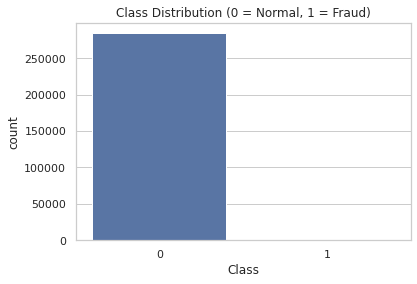

In [6]:
# Class Distribution
print("Class Distribution:\n", df['Class'].value_counts())
sns.countplot(x='Class', data=df)
plt.title("Class Distribution (0 = Normal, 1 = Fraud)")
plt.show()

### Insights:

#### Normal transactions (Class 0): 284,315 (≈ 99.83%)

#### Fraudulent transactions (Class 1): 492 (≈ 0.17%)

### This extreme imbalance is critical because:

#### Standard classifiers may achieve high accuracy by predicting only the majority class.

#### Performance metrics like accuracy become misleading.

#### We must focus on metrics like precision, recall, F1-score, and AUC-ROC.

### Special handling is needed, such as:

#### Undersampling (reduce Class 0)

#### Oversampling (e.g., SMOTE) (increase Class 1)

#### Anomaly Detection approaches

#### Ensemble methods

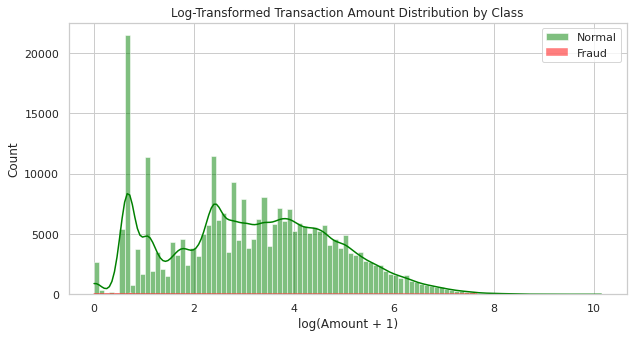

In [7]:
# Create log-transformed column (add 1 to avoid log(0))
df['log_Amount'] = np.log1p(df['Amount'])

# Plot log-transformed distribution
plt.figure(figsize=(10, 5))
sns.histplot(df[df['Class'] == 0]['log_Amount'], bins=100, color='green', label='Normal', kde=True)
sns.histplot(df[df['Class'] == 1]['log_Amount'], bins=100, color='red', label='Fraud', kde=True)
plt.legend()
plt.title("Log-Transformed Transaction Amount Distribution by Class")
plt.xlabel("log(Amount + 1)")
plt.ylabel("Count")
plt.show()

### Insights:

#### Fraudulent transactions (red line) are mostly concentrated in the lower range of log amounts (log(Amount + 1) ≈ 0–4), which corresponds to small real-world transaction values (~$1–$50).

#### Normal transactions (green line) span a much wider range of log-transformed values — indicating more variability and higher maximum amounts.

#### The mode (peak) of normal transactions is around log(Amount) ≈ 1.5 (~$3.5).

#### There's almost no fraud activity at high amounts, which may be intentional to avoid detection.

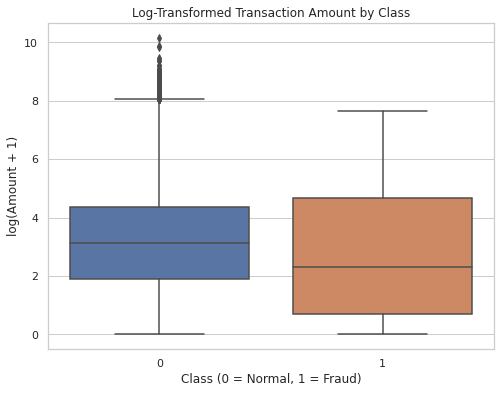

In [8]:
# Boxplot using log-transformed amount
plt.figure(figsize=(8, 6))
sns.boxplot(x='Class', y='log_Amount', data=df)
plt.title("Log-Transformed Transaction Amount by Class")
plt.xlabel("Class (0 = Normal, 1 = Fraud)")
plt.ylabel("log(Amount + 1)")
plt.show()

### Class 0 (Normal):

#### Median: Around log(3) ≈ 1.1

#### IQR: Much wider, showing more variability in transaction amounts

#### Outliers: Some extremely high-value transactions still exist (log > 8)

### Class 1 (Fraud):

#### Median: Lower, around log(1.5) ≈ 0.4

#### IQR: Tighter spread

#### Suggests frauds are consistently low to mid-value

### ➤ This confirms that many fraudulent transactions cluster around lower monetary values — a typical strategy to avoid triggering suspicion.

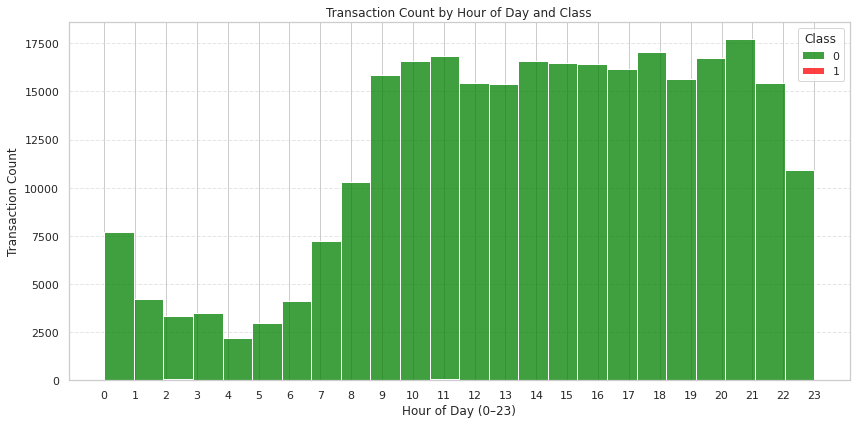

In [9]:
# Convert 'Time' into datetime 
start_time = pd.Timestamp('2013-01-01 00:00:00')
df['Datetime'] = df['Time'].apply(lambda x: start_time + pd.to_timedelta(x, unit='s'))

# Extract hour of day
df['Hour'] = df['Datetime'].dt.hour

# Plot hourly transaction count by class
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Hour', hue='Class', bins=24, multiple='stack', palette={0: 'green', 1: 'red'})
plt.title('Transaction Count by Hour of Day and Class')
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Transaction Count')
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

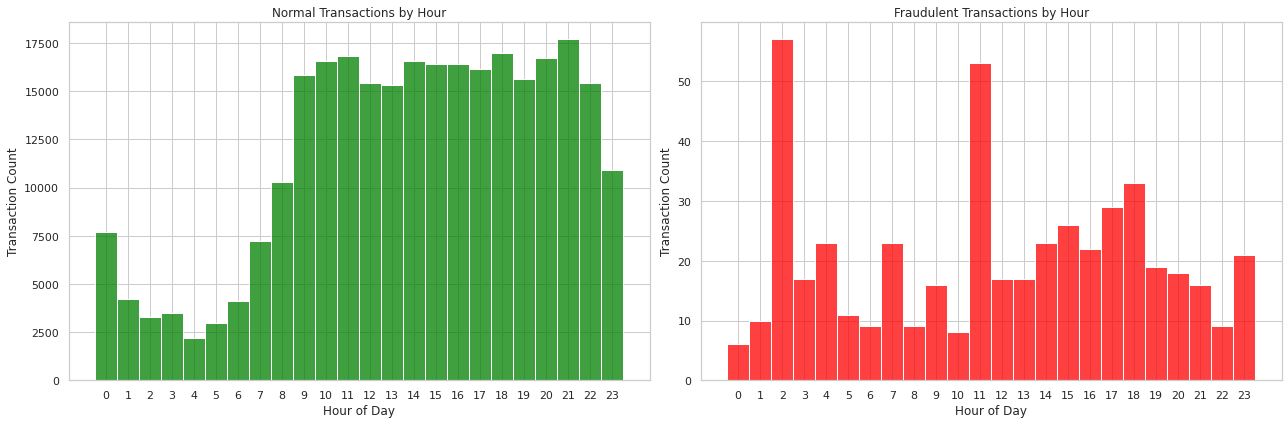

In [10]:
# Prepare figure
fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharey=False)

# Class 0: Normal
sns.histplot(data=df[df['Class'] == 0], x='Hour', bins=24, color='green', ax=axes[0], discrete=True)
axes[0].set_title('Normal Transactions by Hour')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Transaction Count')
axes[0].set_xticks(range(0, 24))

# Class 1: Fraud
sns.histplot(data=df[df['Class'] == 1], x='Hour', bins=24, color='red', ax=axes[1], discrete=True)
axes[1].set_title('Fraudulent Transactions by Hour')
axes[1].set_xlabel('Hour of Day')
axes[1].set_ylabel('Transaction Count')
axes[1].set_xticks(range(0, 24))

# Final layout
plt.tight_layout()
plt.show()

### Normal Transactions (Class = 0)

#### Peak hours: Between 9 AM and 9 PM

#### Low volume: Overnight (midnight to 6 AM)

#### This matches typical human activity patterns

### Fraudulent Transactions (Class = 1)

####  Peak fraud time: Hour 2 (2 AM)

### Feature Selection from Correlation

In [12]:
X = df.drop(columns=['Class', 'Datetime', 'Time', 'log_Amount'], errors='ignore')  
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### SMOTE for Class Balance

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("Before SMOTE:", np.bincount(y_train))
print("After SMOTE:", np.bincount(y_train_res))

## Why **Accuracy is Misleading**

Your dataset is **highly imbalanced**:

* Normal transactions ≈ 284,000
* Fraud ≈ 492

If you predict *everything* as “normal”:

* Accuracy ≈ **99.8%**
* But your model is **useless** (never detects fraud)

 That’s why we throw accuracy out.

---

## Why **F1-score**

* Fraud detection is a **precision-recall tradeoff**:

  * **Precision** → Of all predicted frauds, how many were actually fraud?
  * **Recall** → Of all real frauds, how many did we catch?
* **F1 combines both into one metric**:

[
F1 = 2 \times \frac{Precision \cdot Recall}{Precision + Recall}
]

 This is critical because:

* If recall is high but precision is low → too many false alarms
* If precision is high but recall is low → too many frauds missed
* **F1 balances them**

---

## Why **ROC-AUC**

* ROC-AUC = *Area Under Receiver Operating Characteristic Curve*
* It measures how well the model separates classes **at all thresholds**
* Threshold-independent → doesn’t matter if you pick 0.3, 0.5, or 0.7 probability cutoff
* Good for comparing models holistically

 Example:

* A model with ROC-AUC ≈ **0.98** can almost always rank frauds higher than normal transactions
* Then you can fine-tune the threshold for business needs

---

## Summary

* **F1** = best **single number** for balancing fraud detection trade-offs
* **ROC-AUC** = best **overall measure** of separability, regardless of threshold

| Metric      | Why Use It in Fraud Detection?           |
| ----------- | ---------------------------------------- |
| Accuracy    |  Misleading in imbalance                |
| Precision   |  Important if false alarms cost is high |
| Recall      |  Important if missing fraud is costly   |
| **F1**      |  Best balance (precision + recall)      |
| **ROC-AUC** |  Best overall ranking ability           |

### Models with Cross Validation

#### With SMOTE the models are overfitting, so I decided not to use it. Tree-based models have built-in imbalance handling.
#### Added the hyperparameter to 'Random Forest', 'Extra Trees' and 'LightGBM': class_weight="balanced"
#### Added the hyperparameter to 'XGBoost': scale_pos_weight = (len(y_train[y_train==0]) / len(y_train[y_train==1]))


Running CV for Random Forest...

Running CV for XGBoost...

Running CV for Extra Trees...

Running CV for LightGBM...
                     F1   ROC AUC    PR AUC
LightGBM       0.866563  0.983136  0.847408
Extra Trees    0.853363  0.950244  0.848479
XGBoost        0.742213  0.979108  0.832402
Random Forest  0.696720  0.980904  0.769202


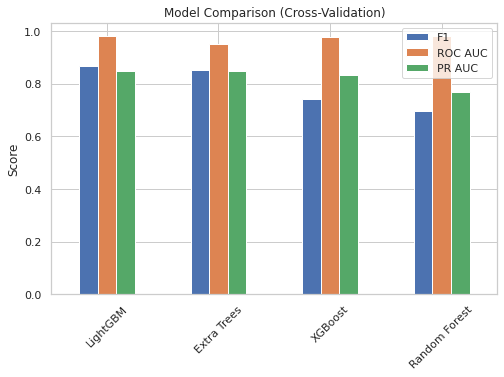

In [17]:
models = {
    "Random Forest": RandomForestClassifier(max_depth=6, n_estimators=100, max_features='sqrt', class_weight="balanced", random_state=42),
    "XGBoost": XGBClassifier(max_depth=4, n_estimators=50, subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='logloss', scale_pos_weight = (len(y_train[y_train==0]) / len(y_train[y_train==1])), random_state=42),
    "Extra Trees": ExtraTreesClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "LightGBM": LGBMClassifier(n_estimators=300, class_weight="balanced", random_state=42)

}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {'f1': 'f1', 'roc_auc': 'roc_auc', 'pr_auc': 'average_precision'}

cv_results = {}

for name, model in models.items():
    print(f"\nRunning CV for {name}...")
    scores = cross_validate(model, X_train, y_train, cv=cv, scoring=scoring)
    cv_results[name] = {
        'F1': np.mean(scores['test_f1']),
        'ROC AUC': np.mean(scores['test_roc_auc']),
        'PR AUC': np.mean(scores['test_pr_auc'])   
    }

# Create dataframe
cv_df = pd.DataFrame(cv_results).T.sort_values(by="F1", ascending=False)
print(cv_df)

# Plot
cv_df.plot(kind='bar', figsize=(8,5))
plt.title("Model Comparison (Cross-Validation)")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.show()

* **LightGBM (F1=0.87, ROC-AUC=0.98, PR-AUC=0.85)** → best overall performer.
* **Extra Trees (F1=0.85, ROC-AUC=0.95, PR-AUC=0.85)** → very competitive, slightly lower ROC.
* **XGBoost (F1=0.74, PR-AUC=0.83)** → decent, but not as strong as LightGBM.
* **Random Forest (F1=0.70, PR-AUC=0.77)** → weaker on both F1 and PR-AUC.

---

## What This Means

* **ROC-AUC values are all high** (as expected in imbalanced data).
* **PR-AUC and F1 are more honest**:

  * They show how well the model really catches fraud without overwhelming false alarms.
  * That’s why LightGBM and Extra Trees stand out, while Random Forest drops off.

---

## The Problem with ROC-AUC in Imbalanced Data

* **ROC-AUC** looks at the tradeoff between True Positive Rate (recall) and False Positive Rate.
* In **imbalanced datasets** (like fraud detection: ~0.2% fraud), the number of true negatives is huge.
* This makes **False Positive Rate artificially small**, so ROC-AUC looks **great (0.95–0.99)** even if the model misses many frauds.

That’s why your models showed **ROC-AUC ≈ 0.98–1.0**, but **F1 ≈ 0.6–0.8** — ROC is over-optimistic.

---

## Why Precision-Recall (PR) AUC Is Better

* **PR-AUC** focuses only on the minority class (fraud = 1):

  * **Precision** = Of all predicted frauds, how many are real frauds?
  * **Recall** = Of all real frauds, how many did we catch?
* The area under the **Precision-Recall curve** shows how well the model balances these two.

 In fraud detection, this is exactly the tradeoff we care about:

* Too high recall → too many false alarms (precision drops)
* Too high precision → too many frauds missed (recall drops)

---

# I've had some problems with overfitting in this fraud detection project. I tried several approaches, and now it's finally under control. You could further improve the models with hyperparameter tuning (using GridSearch or Random Search).